# Generating fake faces using the DCGAN in Pytorch

Today, we're going to re-use the datatset we used in the last notebook to generate fake faces using the [DCGAN Model](https://arxiv.org/pdf/1511.06434.pdf).

A great tutorial exists for the simple DCGAN in PyTorch [here](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html). We'll use the same model and training procedure, and discuss the reasons why this doesnt work as well for our small dataset.

Lets first mount our drive, download our data, and show the dataset.

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.system('mkdir -p /content/drive/MyDrive/DCGAN_pytorch_output')
MODEL_SAVE_DIR = "/content/drive/MyDrive/DCGAN_pytorch_output"
TRAIN_DCGAN = True

In [ ]:
!gdown -q https://drive.google.com/uc?id=1bhR5WTXID9kTxlMmgbKwf3t8-PQUIbTo
!unzip -q /content/destinys_child_data.zip

replace destinys_child_data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
for person in ['beyonce', 'kelly', 'michelle']:
  os.makedirs('/content/{}/train'.format(person), exist_ok=True)
  os.makedirs('/content/{}/test'.format(person), exist_ok=True)
  os.system('cp /content/destinys_child_data/train/{0}/* /content/{0}/train/.'.format(person))

We have a bunch of `torch` imports to add, and we'll also include `numpy`, `matplotlib.pyplot`, and `IPython.displlay.HTML` for display functions.

In [ ]:
# imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import os

import matplotlib.animation as animation
from IPython.display import HTML

IMAGE_SIZE = 64
BATCH_SIZE = 128
FEATURE_SIZE = 100

device = torch.device('cuda')

Lets load our datasets using the `torchvision.datasets.ImageFolder` class. This works with the same structure as we saw with the `tensorflow.keras.preprocessing.image_dataset_from_directory` dataloading function. The structure expects classes to be stored from the root directory as such:

```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```



3


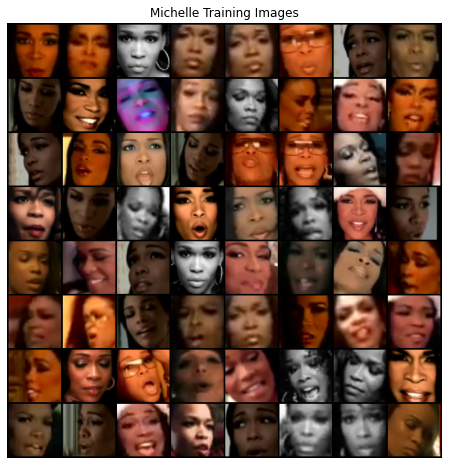

In [ ]:
michelle_dataset = datasets.ImageFolder(root='/content/michelle/',
                               transform=transforms.Compose([
                               transforms.Resize(IMAGE_SIZE),
                               transforms.CenterCrop(IMAGE_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
michelle_dataloader = torch.utils.data.DataLoader(michelle_dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=4)
print(len(michelle_dataloader))
example_batch = next(iter(michelle_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Michelle Training Images")
plt.imshow(np.transpose(vutils.make_grid(example_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

4


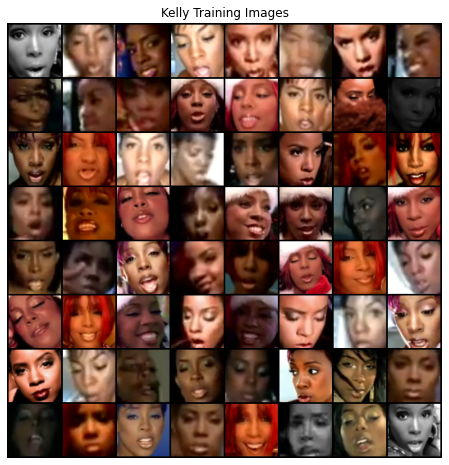

In [ ]:
kelly_dataset = datasets.ImageFolder(root='/content/kelly/',
                               transform=transforms.Compose([
                               transforms.Resize(IMAGE_SIZE),
                               transforms.CenterCrop(IMAGE_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
kelly_dataloader = torch.utils.data.DataLoader(kelly_dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=4)
print(len(kelly_dataloader))

example_batch = next(iter(kelly_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Kelly Training Images")
plt.imshow(np.transpose(vutils.make_grid(example_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

8


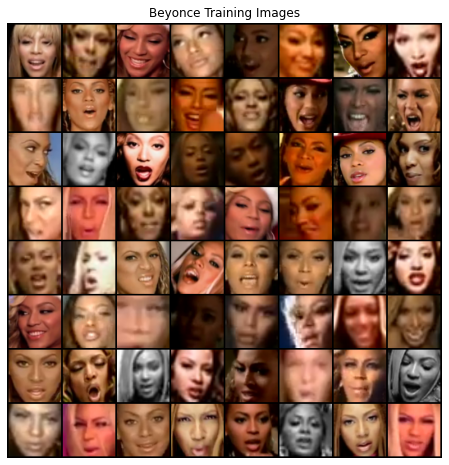

In [ ]:
beyonce_dataset = datasets.ImageFolder(root='/content/beyonce/',
                               transform=transforms.Compose([
                               transforms.Resize(IMAGE_SIZE),
                               transforms.CenterCrop(IMAGE_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
beyonce_dataloader = torch.utils.data.DataLoader(beyonce_dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=4)
print(len(beyonce_dataloader))

example_batch = next(iter(beyonce_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Beyonce Training Images")
plt.imshow(np.transpose(vutils.make_grid(example_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

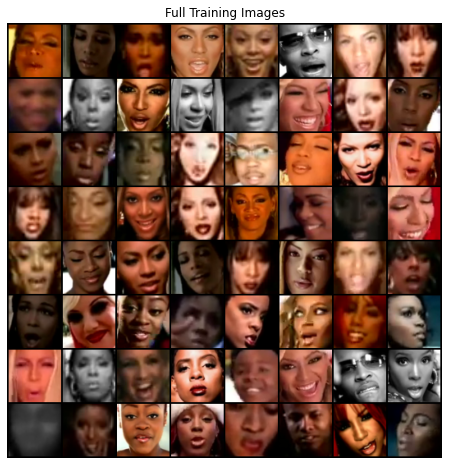

In [ ]:
full_dataset = datasets.ImageFolder(root='/content/destinys_child_data/train/',
                               transform=transforms.Compose([
                               transforms.Resize(IMAGE_SIZE),
                               transforms.CenterCrop(IMAGE_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
full_dataloader =  torch.utils.data.DataLoader(full_dataset, batch_size=BATCH_SIZE,
                                         shuffle=True, num_workers=4)
example_batch = next(iter(full_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Full Training Images")
plt.imshow(np.transpose(vutils.make_grid(example_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Lets talk model design. We'll use the standard GAN architecture, which includes a generator to generate fake images given an input feature vector, as well as a discriminator that generates a label that identifies real vs. fake.

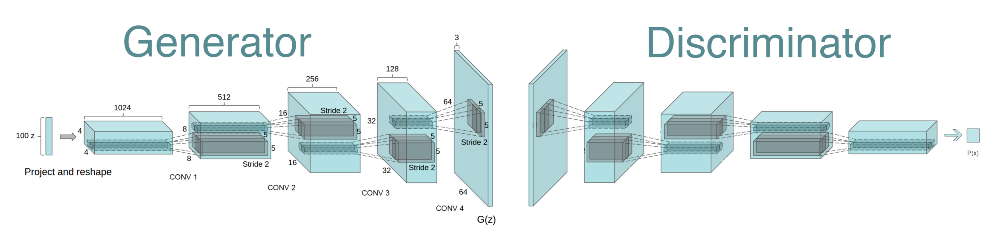

Source: [Gluon DCGAN Docs](https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

features = IMAGE_SIZE
gin_features = FEATURE_SIZE
channels = 3
nc = 3
ndf = 64
ngf = 64
nz = 100


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generate = nn.Sequential(
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
        self.apply(weights_init)
    # create a fake image
    def forward(self, feats):
      return self.generate(feats)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminate = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.apply(weights_init)
    def forward(self, img):
      return self.discriminate(img)

The training procedure has 3 steps:



1.  Calculate error of discriminator identifying a real image as real: `Error(D(x) == REAL)`
2.  Generate a fake image, from an input vector `z`, which is noise. calculate error of discriminator identifying a that generation as fake: `Error(D(G(z)) == FAKE)`
3. Calculate another **adversarial** error term of discriminator identifying that generation as real: `Error(D(G(z)) == REAL`

Over time, our generator gets better at identifying things that are real, but also better at creating fakes that look real. This is why this network is considered *adversarial*, because the first two error terms are directly opposing the second error term.

In [ ]:
def train(modelG, modelD, dataloader, epochs=1000, fixed_generator_input=None):
  global output_images
  # Initialize BCELoss function
  loss = nn.BCELoss()
  # Starting images. Should be random noise, will progress
  # into realistic looking images
  #if fixed_generator_input is None:
  #  fixed_generator_input = torch.randn(BATCH_SIZE, FEATURE_SIZE, 1, 1, device=device) 
  # Establish convention for real and fake labels during training
  real_label = 1.
  fake_label = 0.
  # Setup Adam optimizers for both G and D
  optimizerD = optim.Adam(modelD.parameters(), lr=0.0002, betas=(0.5, 0.999))
  optimizerG = optim.Adam(modelG.parameters(), lr=0.0002, betas=(0.5, 0.999))
  num_epochs = epochs
  fixed_generator_input = torch.randn(BATCH_SIZE, FEATURE_SIZE, 1, 1, device=device) 
  for epoch in range(num_epochs):
      for i, data in enumerate(dataloader, 0):
          # step 1: train discriminator using generated input and real input
          # here we learn to tell what is real and what is fake.
          # maximize log(D(x)) + log(1 - D(G(z)))
          modelD.zero_grad()
          modelG.zero_grad()

          # grab batch
          real_cpu = data[0].to(device)
          b_size = real_cpu.size(0)
          label = torch.full((b_size,), real_label, dtype=torch.float, device=device)

          # Forward/backward
          output = modelD(real_cpu).view(-1)
          errD_real = loss(output, label)
          errD_real.backward()
          score_real = output.mean().item()

          ## Repeat with generated fake at this class.
          noise = torch.randn(b_size, 100, 1, 1, device=device)
          fake = modelG(noise)

          label.fill_(fake_label)

          # Forward backward
          output = modelD(fake.detach()).view(-1)
          errD_fake = loss(output, label)
          errD_fake.backward()
          score_1 = output.mean().item() # score on current fake
          
          errD = errD_real + errD_fake # save discriminator error for printing
          optimizerD.step() # update model

          # step 2: train generator using thhe input we already generated
          # here we learn to generate things that the discriminator thinks are real.
          # same as above, but backwards, only on the fake image.

          label.fill_(real_label)  
          output = modelD(fake).view(-1) # use the same output because we dont 
                                      # need to generate another
          errG = loss(output, label)
          errG.backward()
          score_2 = output.mean().item()
          optimizerG.step()

          # Stats every so often
          if (epoch+1) % 250 == 0 and (i+1) % len(dataloader) == 0:
              print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch+1, num_epochs, i+1, len(dataloader),
                      errD.item(), errG.item(), score_real, score_1, score_2))
          # Visualize on that fixed random input
      if epoch == 0 or (epoch+1) % 50 == 0:
          with torch.no_grad():
              fake = modelG(fixed_generator_input).detach().cpu()
          output_images.append(fake)
  return output_images

In [ ]:
%%time
global output_images
torch.autograd.set_detect_anomaly(True)
outputs = {}

for person, dataloader, epochs in zip(['kelly', 'michelle', 'beyonce', 'full'], [kelly_dataloader, michelle_dataloader, beyonce_dataloader, full_dataloader], [1500, 1500, 1000, 500]):
  output_images = []
  gen = Generator().to(device)
  disc = Discriminator().to(device)
  print('Training a {} DCGAN...'.format(person.capitalize()))
  train(gen, disc, dataloader, epochs)
  outputs[person] = (gen, disc, output_images)
  print('{} DCGAN Complete.'.format(person.capitalize()))

  gen, disc, output_imgs = outputs[person]
  dir_ = os.path.join(MODEL_SAVE_DIR, '{}_DCGAN_MODEL'.format(person))
  os.makedirs(dir_, exist_ok=True)
  torch.save({
      'modelG': gen.state_dict(),
      'modelD': disc.state_dict(),
      'output_images': output_imgs,
  }, os.path.join(dir_, '{}_dcgan_model.pth'.format(person)))

Looking at the outputs, we see that they kinda look like real faces, but have a werid, warped quality to them.

In [ ]:
# Plot the real images
#train(beyG, beyD, beyonce_dataloader)
output_images = outputs['beyonce'][2]
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Beyonce Images")
plt.imshow(np.transpose(vutils.make_grid(next(iter(beyonce_dataloader))[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fixed start images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Beyonce Images")
plt.imshow(np.transpose(vutils.make_grid(output_images[-1][:64], padding=5, normalize=True),(1,2,0)))
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(vutils.make_grid(i[:64], padding=5, normalize=True),(1,2,0)), animated=True)] for i in output_images]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Plot the real images
output_images_kelly = outputs['kelly'][2]
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Kelly Images")
plt.imshow(np.transpose(vutils.make_grid(next(iter(kelly_dataloader))[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fixed start images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Kelly Images")
plt.imshow(np.transpose(vutils.make_grid(output_images_kelly[-1][:64], padding=5, normalize=True),(1,2,0)))
plt.show()

In [ ]:
output_images_michelle = outputs['michelle'][2]
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Michelle Images")
plt.imshow(np.transpose(vutils.make_grid(next(iter(michelle_dataloader))[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fixed start images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Michelle Images")
plt.imshow(np.transpose(vutils.make_grid(output_images_michelle[-1][:64], padding=5, normalize=True),(1,2,0)))
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(vutils.make_grid(i[:64], padding=5, normalize=True),(1,2,0)), animated=True)] for i in output_images_michelle]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
output_images_full = outputs['full'][2]
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(next(iter(full_dataloader))[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fixed start images
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(output_images_full[-1][:64], padding=5, normalize=True),(1,2,0)))
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(vutils.make_grid(i[:64], padding=5, normalize=True),(1,2,0)), animated=True)] for i in output_images_full]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

There are two better generative models, the [ProgressiveGAN (PGAN)](https://arxiv.org/pdf/1710.10196.pdf) and [StyleGAN](https://arxiv.org/abs/1812.04948).

PGAN creates fakes at increasing scale sizes, resulting in higher quality and higher resolution fakes at each step.

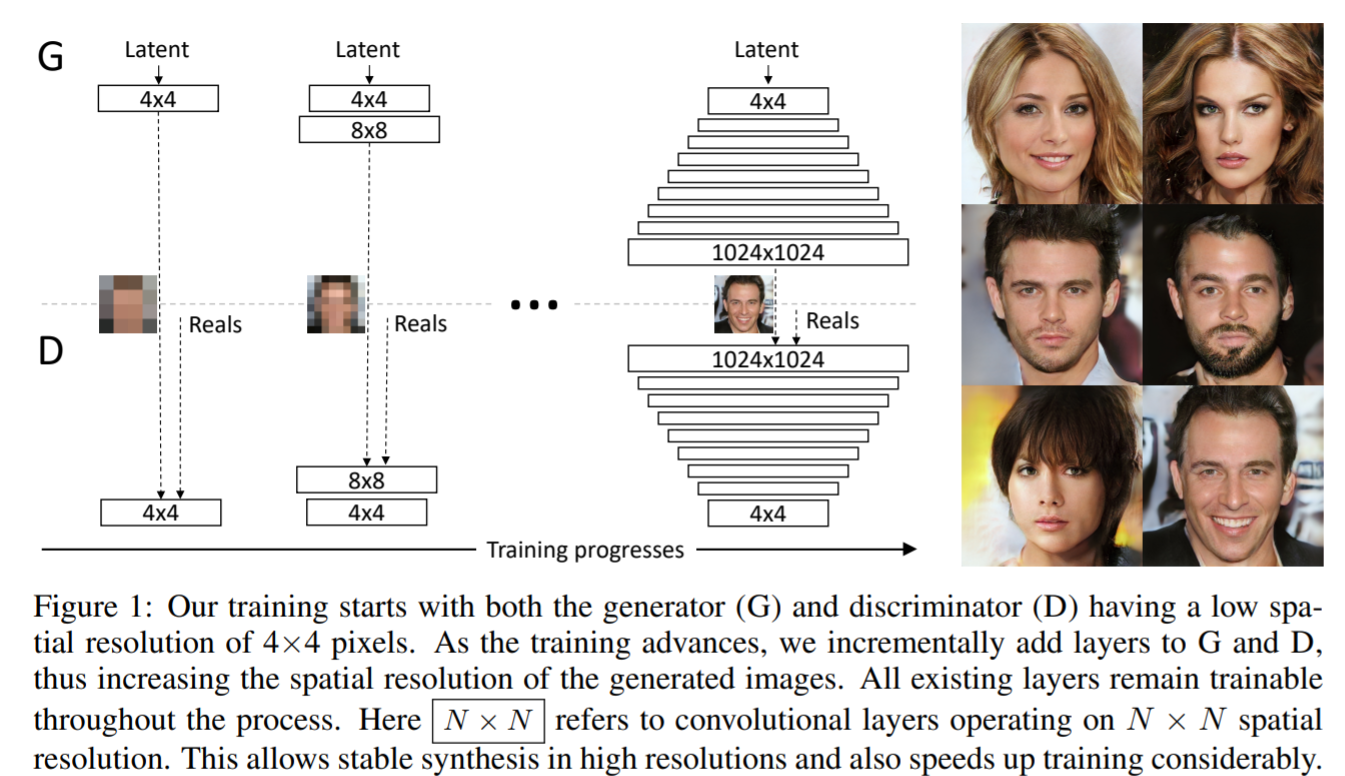

Source: [Progressive Growing of GANS for Improved Quality, Stability and Variation, *Karras et. al.*](https://arxiv.org/pdf/1710.10196.pdf)

StyleGAN gives more control over the fakes, allowing us to match the stylistic qualities of faces in each image (hair texture, skin/hair/eye color) while somewhat maintaining features of input images.

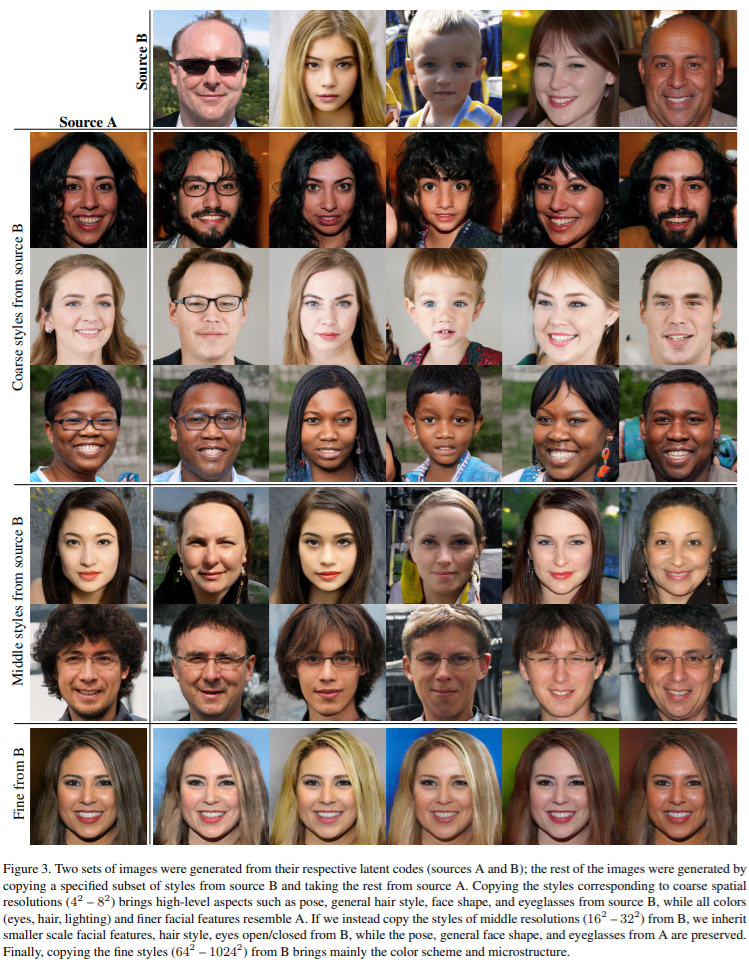

Source: [A Style-Based Generator Architecture for Generative Adversarial Networks, *Karras et. al.*
](https://arxiv.org/pdf/1812.04948.pdf)

Check out the papers for more details, and also checkout the [PyTorch GAN Model Zoo](https://github.com/facebookresearch/pytorch_GAN_zoo) which provides end-to-end training and evaluation code for both of these models so you don't have to write them yourself.

Note that these algorithms take a very long time (days to a week or two) to train, even on GPU, because of the complexity of training and quality of the output models.

That's it for this series! [subscribe to my YouTube Channel](https://www.youtube.com/channel/UCvVAxOBEAMgu7WwTcFptt-w?sub_confirmation=1) for more tutorials and tech videos like this!